# Skip-gram Word2Vec

## Хорошие ссылки для чтения


* Полезный [общий взгляд](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) на Word2Vec
* [Первые работы с Word2Vec](https://arxiv.org/pdf/1301.3781.pdf) 
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) с улучшениями Word2Vec 

---
## Word embeddings

Когда вы имеете дело со словами в тексте, вам приходится анализировать десятки тысяч классов слов; по одному для каждого слова в словаре. Попытка однократно закодировать эти слова крайне неэффективна, потому что большинство значений в one-hot-encoding векторе будут установлены на ноль. Таким образом, умножение матриц, которое происходит между одним one-hot-encoding входным вектором и первым, скрытым слоем, приведет в основном к скрытым выходным данным с нулевым значением.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/one_hot_encoding.png?raw=1' width=50%>

Чтобы решить эту проблему и значительно повысить эффективность наших сетей, мы используем так называемые **эмбеддинги**. Эмбеддинги - это просто полностью связанный слой, как вы видели раньше. Мы называем этот слой вложенным слоем, а веса - вложенными весами. Мы пропускаем умножение в слой эмбеддингов, вместо этого напрямую извлекая значения скрытого слоя из весовой матрицы. Мы можем сделать это, потому что умножение one-hot-encoding вектора на матрицу возвращает строку матрицы, соответствующую индексу входного блока "on".

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/lookup_matrix.png?raw=1' width=50%>

Вместо того, чтобы выполнять умножение матриц, мы используем матрицу весов в качестве таблицы поиска. Мы кодируем слова как целые числа, например, «сердце» кодируется как 958, «разум» как 18094. Затем, чтобы получить значения скрытого слоя для «сердца», вы просто берете 958-ю строку матрицы эмбеддингов. Этот процесс называется **поиском эмбеддинга**, а количество скрытых единиц - **измерением эмбеддинга**.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/tokenize_lookup.png?raw=1' width=50%>
 
Здесь нет ничего волшебного. Таблица эмбеддингов - это просто весовая матрица. Слой эмбеддинга - это просто скрытый слой. Поиск - это просто ярлык для умножения матриц. Таблица поиска обучается так же, как и любая матрица весов.

Конечно, эмбеддинги используются не только для слов. Вы можете использовать их для любой модели, где у вас огромное количество классов. Конкретный тип модели под названием **Word2Vec** использует слой эмбеддингов для поиска векторных представлений слов, содержащих семантическое значение.

---
## Word2Vec

Алгоритм Word2Vec находит гораздо более эффективные представления, находя векторы, представляющие слова. Эти векторы также содержат семантическую информацию о словах.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/context_drink.png?raw=1" width=40%>

Слова, которые появляются в похожих **контекстах**, таких как «кофе», «чай» и «вода», будут иметь векторы рядом друг с другом. Различные слова будут дальше друг от друга, а отношения могут быть представлены расстоянием в векторном пространстве.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/vector_distance.png?raw=1" width=40%>


Есть две архитектуры для реализации Word2Vec:
>* CBOW (Continuous Bag-Of-Words) и 
* Skip-gram

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/word2vec_architectures.png?raw=1" width=60%>

В этой реализации мы будем использовать **архитектуру skip-gram**, потому что она работает лучше, чем CBOW. Здесь мы передаем слово и пытаемся предсказать слова, окружающие его в тексте. Таким образом, мы можем обучить сеть изучать представления слов, которые появляются в схожих контекстах.

---
## Loading Data

Для начала скачаем данные

1. Скачаем [dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip); файл очищенного *текста статьи в Википедии* от Мэтта Махони.
2. Расположим эти данные в  `data`.
3. Затем удалим скачанный файл для экономии памяти

После этого мы оставим только один файл в репозитории: `data/text8`.

In [ ]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip 
!unzip text8.zip
!rm text8.zip

--2020-12-12 18:26:02--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  79.0MB/s    in 0.4s    

2020-12-12 18:26:02 (79.0 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [ ]:
# read in the extracted text file      
with open('text8') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


## Pre-processing

Здесь мы чистим текст, чтобы облегчить обучение. Это происходит из файла `utils.py`. Функция `preprocess` делает несколько вещей:
>* Он преобразует любые знаки препинания в токены, поэтому точка заменяется на `<PERIOD>`. В этом наборе данных нет никаких периодов, но это поможет при решении других задач. 
* Он удаляет все слова, которые встречаются в наборе данных пять или *меньше* раз. Это значительно уменьшит проблемы, связанные с шумом в данных, и улучшит качество векторных представлений.
* Он возвращает список слов в тексте.

Это может занять несколько секунд, так как наш текстовый файл довольно большой. Если вы хотите написать свои собственные функции для этого материала, дерзайте!

In [ ]:
# Импортируем кастомный модуль

import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/khaykingleb/Deep-Learning/master/seminars/sem_09/utils_.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('utils_.py', 'w') as f:
    f.write(r.text)

import utils_

In [ ]:
# get list of words
words = utils_.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [ ]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 16680599
Unique words: 63641


### Dictionaries

Затем мы создаем два словаря для преобразования слов в целые числа и обратно (целые числа в слова). Это снова делается с помощью функции из файла `utils.py`. create_lookup_tables принимает список слов в тексте и возвращает два словаря.
>* Целые числа присваиваются в порядке убывания частоты, поэтому самому частому слову («the») присваивается целое число 0, а следующему по частоте - 1 и так далее. 

Когда у нас есть словари, слова преобразуются в целые числа и сохраняются в списке int_words.

In [ ]:
vocab_to_int, int_to_vocab = utils_.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


## Subsampling

Часто встречающиеся слова, такие как «the», «of» и «for», не обеспечивают особого контекста для близлежащих слов. Если мы отбросим некоторые из них, мы сможем удалить часть шума из наших данных и взамен получить более быстрое обучение и лучшее представление. Этот процесс Миколов назвал субдискретизацией. Для каждого слова $w_i$ в обучающем наборе мы отбрасываем его с вероятностью, равной

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

где $t$ - пороговый параметр, а $f(w_i)$ - частота слова $w_i$ в общем наборе данных.

$$ P(0) = 1 - \sqrt{\frac{1\cdot10^{-5}}{1\cdot10^6/16\cdot10^6}} = 0.98735 $$

Это остается вам в качестве упражнения. 

> **Упражнение:** Реализуйте подвыборку для слов в `int_words`. То есть пройдите через `int_words` и отбросьте каждое слово с вероятностью $ P (w_i) $, показанной выше. Обратите внимание, что $ P (w_i) $ - это вероятность того, что слово будет отброшено. Назначьте данные с подвыборкой для `train_words`.

In [ ]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
# dictionary of int_words, how many times they appear
print(list(word_counts.items())[0]) 

(5233, 303)


In [ ]:
freq = {int_word: count / len(int_words) for int_word, count in word_counts.items()}
list(freq.items())[:5]

[(5233, 1.8164815304294527e-05),
 (3080, 3.4291334501836536e-05),
 (11, 0.007902294156223047),
 (5, 0.01953604903516954),
 (194, 0.00043277822337195443)]

In [ ]:
p = {int_word: 1 - np.sqrt(threshold / freq[int_word]) for int_word, count in word_counts.items()}
list(p.items())[:5]

[(5233, 0.25803314192489146),
 (3080, 0.4599825339524992),
 (11, 0.9644267615025448),
 (5, 0.9773753623879587),
 (194, 0.8479917006734952)]

In [ ]:
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [int_word for int_word in int_words if np.random.random() > p[int_word]]

print(train_words[:30])

[5233, 3080, 3133, 476, 10571, 27349, 15067, 58112, 854, 3580, 10712, 2731, 362, 3672, 97, 7088, 5233, 1052, 44611, 186, 5233, 19, 8983, 279, 4147, 6437, 4186, 5233, 447, 1818]


In [ ]:
train_words.__len__()

4626109

## Making batches

Теперь, когда наши данные в хорошей форме, нам нужно привести их в правильную форму, чтобы передать их в нашу сеть. В архитектуре skip-gram для каждого слова в тексте мы хотим определить окружающий _context_ и захватить все слова в окне вокруг этого слова с размером $ C $. 

Из [статьи.](https://arxiv.org/pdf/1301.3781.pdf): 

"Поскольку более далекие слова обычно меньше связаны с текущим словом, чем близкие к нему, мы придаем меньший вес удаленным словам, отбирая меньшее количество из этих слов в наших обучающих примерах ... Если мы выберем $ C = 5 $, то для каждого обучающего слова мы выбираем случайным образом число $ R $ в диапазоне $ [1: C] $, а затем используем слова $ R $ из предыдущих слов и слова $ R $ из будущего текущего слова в качестве правильных меток."

> **Упражнение:** Реализуйте функцию get_target, которая получает список слов, индекс и размер окна, а затем возвращает список слов в окне вокруг индекса. Обязательно используйте алгоритм, описанный выше, где вы выбрали случайное количество слов из окна.

Скажем, у нас есть вход, и нас интересует токен idx = 2, `741`: 
```
[5233, 58, 741, 10571, 27349, 0, 15067, 58112, 3580, 58, 10712]
```

Для R = 2 функция get_target должна возвращать список из четырех значений:
```
[5233, 58, 10571, 27349]
```

In [ ]:
def get_target(words, idx, window_size=5):
    ''' 
    Get a list of words in a window around an index. 
    
    '''
    
    R = np.random.randint(1, window_size + 1)
    target = words[max(0, idx - R):idx] + words[idx+1:idx+R+1]

    return target

In [ ]:
# test your code!

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]


### Generating Batches 

Вот функция-генератор, которая возвращает пакеты входных и целевых данных для нашей модели, используя функцию get_target, описанную выше. Идея в том, что он берет слова `batch_size` из списка слов. Затем для каждого из этих пакетов слова отображаются в окне.

In [ ]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [ ]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 2]


Для слова 0 получили контекстные слова 1 и 2; для слова 1 — контекстные слова 0, 2, 3 и т.д.

In [ ]:
x,y = next(get_batches(train_words, batch_size=7, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [5233, 5233, 5233, 5233, 3080, 3080, 3133, 3133, 476, 476, 476, 476, 476, 476, 10571, 10571, 10571, 10571, 10571, 10571, 27349, 27349, 27349, 15067]
y
 [3080, 3133, 476, 10571, 5233, 3133, 3080, 476, 5233, 3080, 3133, 10571, 27349, 15067, 5233, 3080, 3133, 476, 27349, 15067, 476, 10571, 15067, 27349]


## Building the graph

Ниже представлена ​​примерная схема общей структуры нашей сети.

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/skip_gram_arch.png?raw=1" width=60%>

>* Входные слова передаются как пакеты токенов входных слов. 
* Они входят в скрытый слой линейных единиц (наш слой эмбеддинга). 
* Затем, наконец, в выходной слой softmax. 

Мы будем использовать слой softmax, чтобы делать предсказания о контекстных словах, как обычно.

Идея состоит в том, чтобы обучить матрицу весов слоя эмбеддингов и найти эффективные представления для наших слов. Мы можем отбросить слой softmax, потому что нам не нужно делать прогнозы с помощью этой сети. Нам просто нужна матрица эмбеддингов, чтобы мы могли использовать ее в _других_ сетях, которые мы строим с использованием этого набора данных.

---
## Validation

Здесь нужно создать функцию, которая поможет нам наблюдать за нашей моделью в процессе обучения. Нужно выбрать несколько общих слов и несколько необычных слов. Затем мы распечатаем ближайшие к ним слова, используя косинусное сходство:

<img src="https://github.com/udacity/deep-learning-v2-pytorch/blob/master/word2vec-embeddings/assets/two_vectors.png?raw=1" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


Мы можем закодировать слова проверки как векторы $\vec{a}$, используя таблицу эмбеддингов, а затем вычислить сходство с каждым вектором слов $\vec{b}$ в таблице эмбеддингов. Имея сходство, мы можем распечатать проверочные слова и слова в нашей матрице эмбеддингов, семантически похожие на эти слова. Это хороший способ проверить, объединяет ли наша таблица эмбеддингов слова с похожими семантическими значениями.

In [ ]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model

Определите и обучите модель SkipGram. 
> Вам нужно будет определить [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) и последний выходной слой softmax.

Слой внедрения принимает ряд входных данных:
* **num_embeddings** – размер словаря эмбеддингов или сколько строк вы хотите в матрице эмбеддингов
* **embedding_dim** – размер каждого вектора эмбеддинга; размер эмбеддинга

In [ ]:
import torch
from torch import nn
import torch.optim as optim

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.fc = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, x):
        out = self.embed(x)
        out = self.fc(out)
        out = self.log_softmax(out)
        
        return out

### Training

**Обратите внимание: поскольку мы применили функцию softmax к выходным данным нашей модели, мы используем NLLLoss**, а не перекрестную энтропию. Это потому, что Softmax в сочетании с NLLLoss = CrossEntropy loss.

In [ ]:
#check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 3

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

time | pac, cumbria, kael, barsoomian, ilium
it | assembleia, regressive, tupac, yc, dunant
can | anduin, valdez, rapid, quirks, crokinole
there | adoptive, responses, hierarchically, rebaptized, veteris
six | ukrainians, corkscrew, coffee, borrows, buckler
also | hardwicke, leutze, nietzsche, justin, shortages
the | kub, ablett, seimas, forgent, renner
between | loops, story, dispersal, creeds, odoacer
shown | artemisia, seller, rosebud, dysprosium, severus
http | delmarva, caucus, apaches, cytosol, flageolet
scale | disproportionately, trowa, gprs, mejid, adventist
existence | agnew, thirtieth, ebitda, hw, doyle
mathematics | huike, postulating, termite, fretted, roca
behind | pratt, dressers, barrier, gorda, filthy
professional | because, embezzlement, mta, plains, ghaznavid
governor | theorem, slit, estrada, taifa, adamantly
...
years | pearl, cigarette, kerala, ingenioso, ode
all | feynman, pairwise, comintern, abstractions, insurgencies
in | designed, rhee, luca, interrupted, sti

KeyboardInterrupt: ignored

## Visualizing the word vectors

Ниже мы будем использовать T-SNE, чтобы визуализировать, как наши многомерные словесные векторы группируются вместе. Прочитать [эту статью](http://colah.github.io/posts/2014-10-Visualizing-MNIST/), чтобы узнать больше о T-SNE и других способах визуализации многомерных данных.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

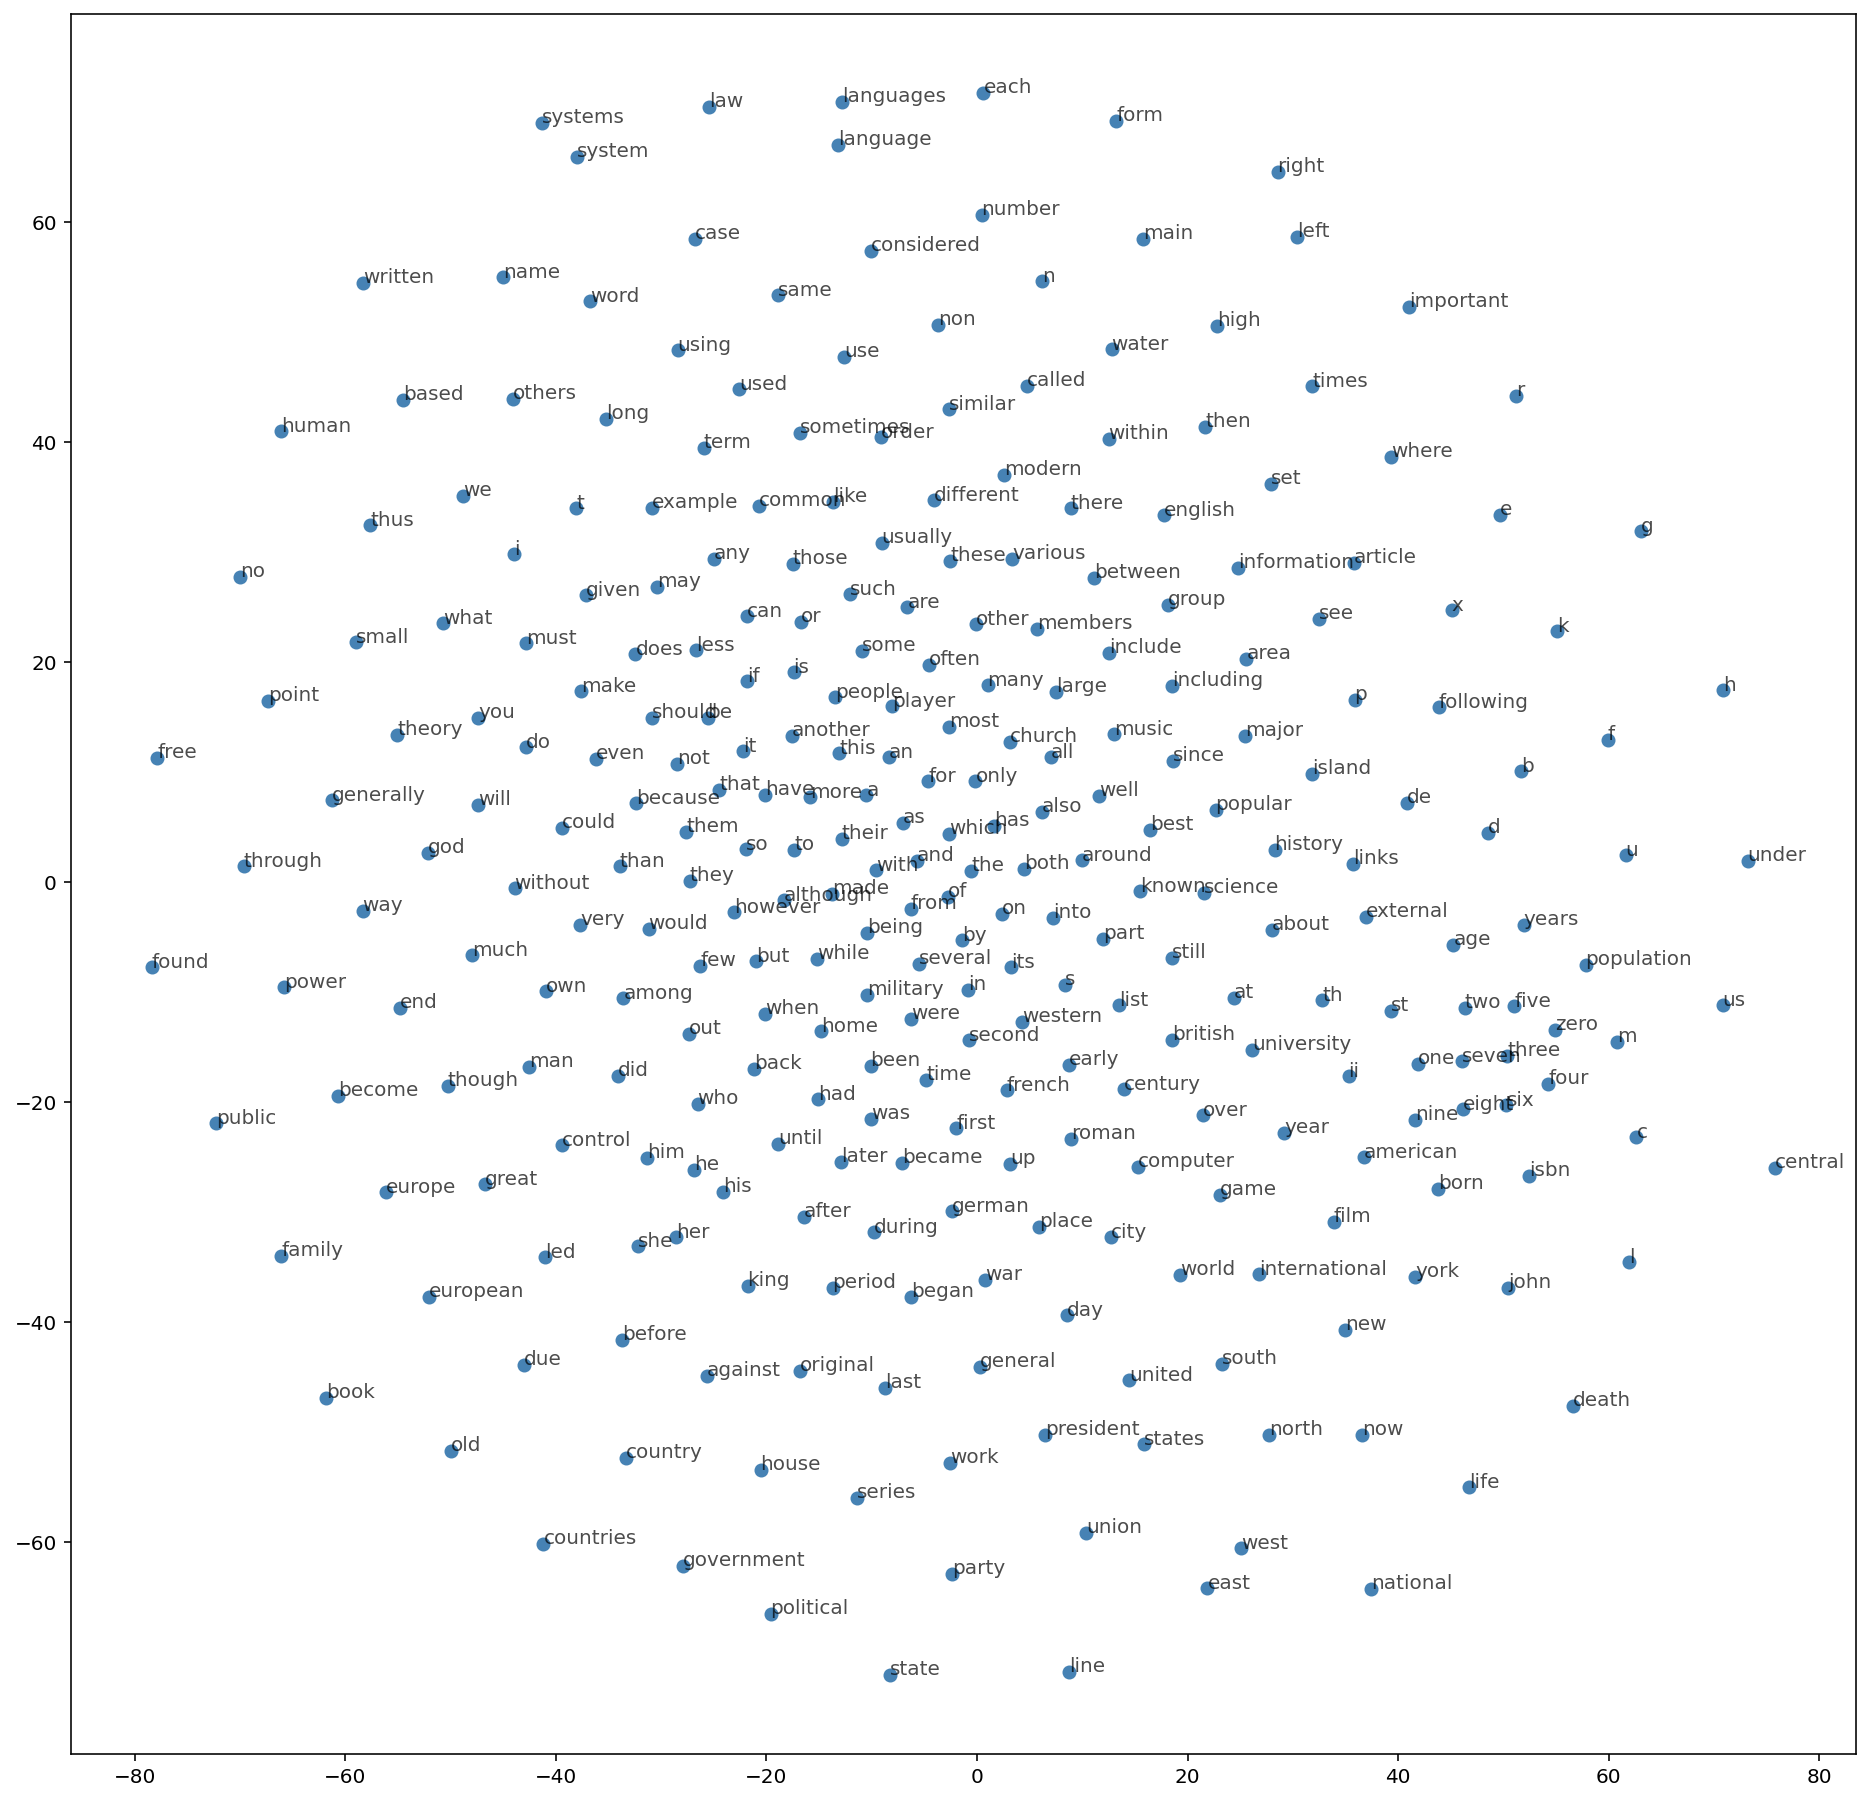

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)